# Visual Understanding of Self Driving Car Model

The SDC model submitted is a refined version of pretrained VGG16. Visualize how the SDC model sees the world, and thus understand why it behaves in such a way.

## How
### 1. visualize the filters
- see [keras examples](https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py) on this. Since most part of SDC is from VGG16, I expect to see very similiar filter visulizations here, so not tried

### 2. visualize the outputs of certain middle layers
After getting the layer output, there are several ways of visualizing them, e.g,
- Use ***decovolution layer*** to map the conv activation back to the input image space - not tried
- Directly interpret the output of middle layers, e.g., by ***resizing*** the output and combining it with the original image: bigger absolute values of outputs indicate important pixels. This can be viewed as a ***"cheap approximation" of deconvolution*** - results shown below

In [1]:
%matplotlib inline

import argparse

import keras
import keras.backend as K
K.set_image_dim_ordering("tf")
from keras.models import load_model, Model

import numpy as np
import matplotlib.pyplot as plt
import os

from sdc import process
from sdc import model
from sdc import config

from scipy.misc import imresize, imread
import tensorflow as tf


Using TensorFlow backend.
/Users/thomastracey/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print('Keras version: ', keras.__version__)
print('Tensorflow version: ', tf.__version__)
print('Keras backend: ', keras.backend.backend())
print('keras.backend.image_dim_ordering = ', keras.backend.image_dim_ordering())

os.environ["KERAS_BACKEND"] = "tensorflow"
if keras.backend.backend() != 'tensorflow':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('tf')
    print("\nBackend OK")

Keras version:  2.0.6
Tensorflow version:  1.0.0
Keras backend:  tensorflow
keras.backend.image_dim_ordering =  tf

Backend OK


## plot layer output as images

In [13]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def visualize_outputs(img_files, layer="block2_conv1", topn=8, img_size=(64, 64)):
    """img_files: filenames of input images
    layer: name of layer of which the outputs are visualized
    topn: number of top filters to show (ranked on their mean absolute values)
    img_size: target size of each image in grid
    Return: grid image as numpy array with dimension = nimgs x topn+1, each img has size
    of img_size
    """
    h, w = img_size
    
    # load original images
    raw_imgs = []
    imgs = []
    process_img = config.processors["CenterImage"]
    for image_path in img_files:
        raw_img = imread(image_path)
        raw_img = imresize(raw_img, (h, w))
        raw_imgs.append(raw_img)
        img = imresize(process_img(image_path), (h, w))
        imgs.append(img)
    imgs = np.stack(imgs, axis=0)
        
    # get layer output
    with tf.Session() as sess:
        K.set_session(sess)

        # restore keras model
#         sdc_model = model.SteerRegressionModel(input_shape=config.image_size, model=config.model_name)
#         sdc_model.restore("models/model.h5")
#         train_model = sdc_model.model
        
        model = load_model('../model.h5')        
        
        # build a new model to output the certain layer 
        visual_model = Model(model.input, model.get_layer(layer).output)

        # generate output
        layer_output = visual_model.predict(imgs)
        layer_output = np.abs(layer_output)
        layer_output = (layer_output - layer_output.min()) / (layer_output.max() - layer_output.min())

    # find top filters for each image and combine them with original image
    plot_img = np.zeros((len(raw_imgs)*h, (topn+1)*w, 3))
    for i, raw_img in enumerate(raw_imgs):
        output = np.abs(layer_output[i, ...])
        # filter scores as mean absolute values of activations
        filter_scores = output.reshape((-1, output.shape[-1])).max(axis=0)
        topn_filters = np.argsort(filter_scores)[-topn:]
        plot_img[i*h:(i*h+h), :w, :] = raw_img
        for n, ifilter in enumerate(topn_filters):
            mask = imresize(output[:, :, ifilter], (h, w))
#             mask = mask >= 0.5
            filter_img = raw_img.astype(np.float32) * np.expand_dims(mask, -1)
            plot_img[i*h:(i*h+h), (n+1)*w:((n+1)*w+w), :] = deprocess_image(filter_img)
    return plot_img.astype(np.uint8)

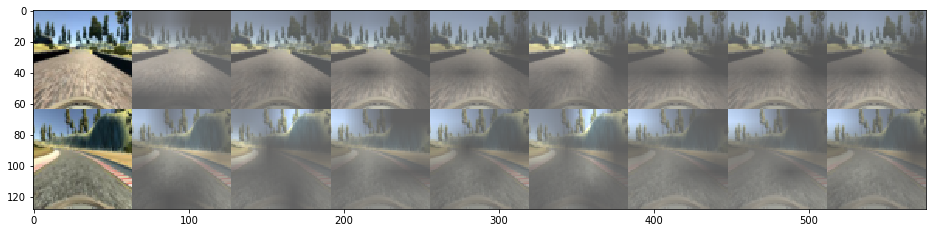

In [14]:
# test
# img_files = ["data/t1rr1/IMG/center_2016_11_14_21_07_22_395.jpg"
#             , "data/t1r4/IMG/center_2016_11_14_20_47_06_256.jpg"]

img_files = ["../data/track1/track1-slow/IMG/center_2017_08_23_22_32_40_476.jpg", 
            "../data/track1/track1-slow/IMG/center_2017_08_23_19_36_33_327.jpg"
            ]
a = visualize_outputs(img_files)
plt.figure(figsize=(16, 16))
plt.imshow(a.astype(np.uint8))

## find interesting images from result

results on test data are stored in tmp/test_result.csv

In [96]:
import pandas as pd
df = pd.read_csv("tmp/test_result.csv")
df = df[~df.image.str.endswith("mirror")] # remove artificial generated mirror images
df["error"] = np.abs(df["steer"]-df["prediction"]) # l1 error
print (df.shape)
df.head()

(5027, 4)


image  prediction     steer  \
0  data/t1r4/IMG/center_2016_11_14_20_47_49_315.jpg   -0.003067  0.000000   
2  data/t1w1/IMG/center_2016_11_16_21_10_52_688.jpg    0.003269  0.000000   
3  data/t1r2/IMG/center_2016_11_07_21_30_22_813.jpg   -0.160640  0.000000   
6  data/t1r5/IMG/center_2016_11_14_20_56_05_838.jpg   -0.098433 -0.221481   
8  data/t1r4/IMG/center_2016_11_14_20_47_32_208.jpg   -0.067421  0.000000   

      error  
0  0.003067  
2  0.003269  
3  0.160640  
6  0.123048  
8  0.067421

In [97]:
np.random.seed(314)

building vgg16_pretrained model


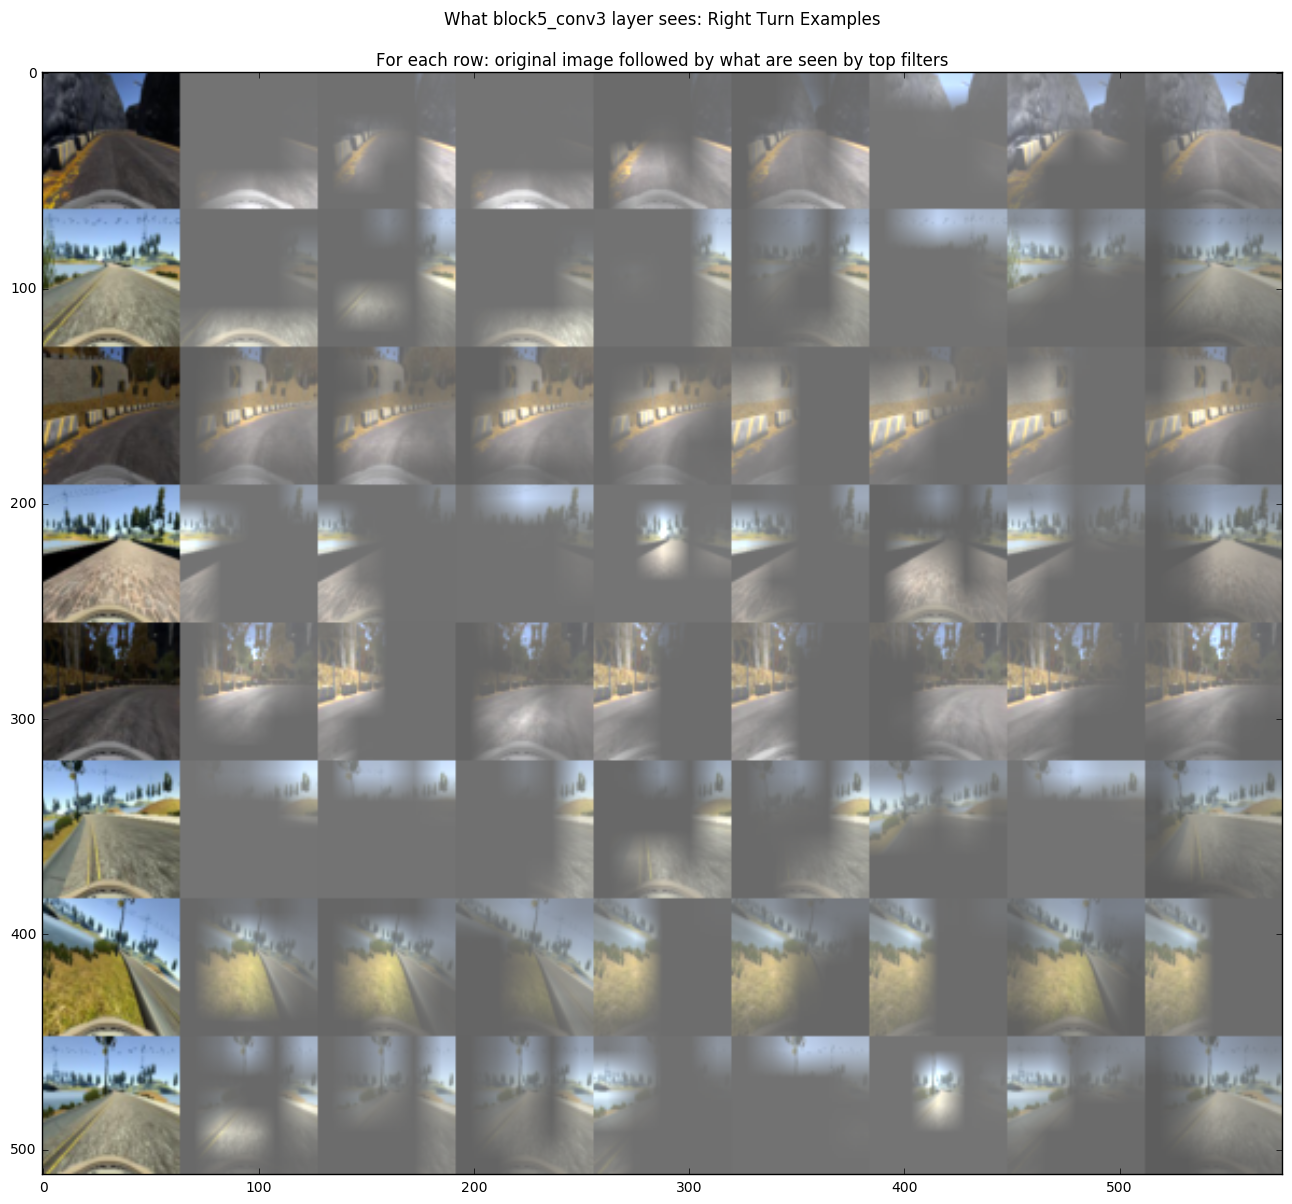

In [98]:
right_steer_imgs = list(df[df.steer > 0.75].image.sample(8))
right_steer_filter_plots = visualize_outputs(right_steer_imgs, topn=8)
plt.figure(figsize = (16, 16))
plt.imshow(right_steer_filter_plots)
plt.title("""What block5_conv3 layer sees: Right Turn Examples
          \nFor each row: original image followed by what are seen by top filters""")

building vgg16_pretrained model


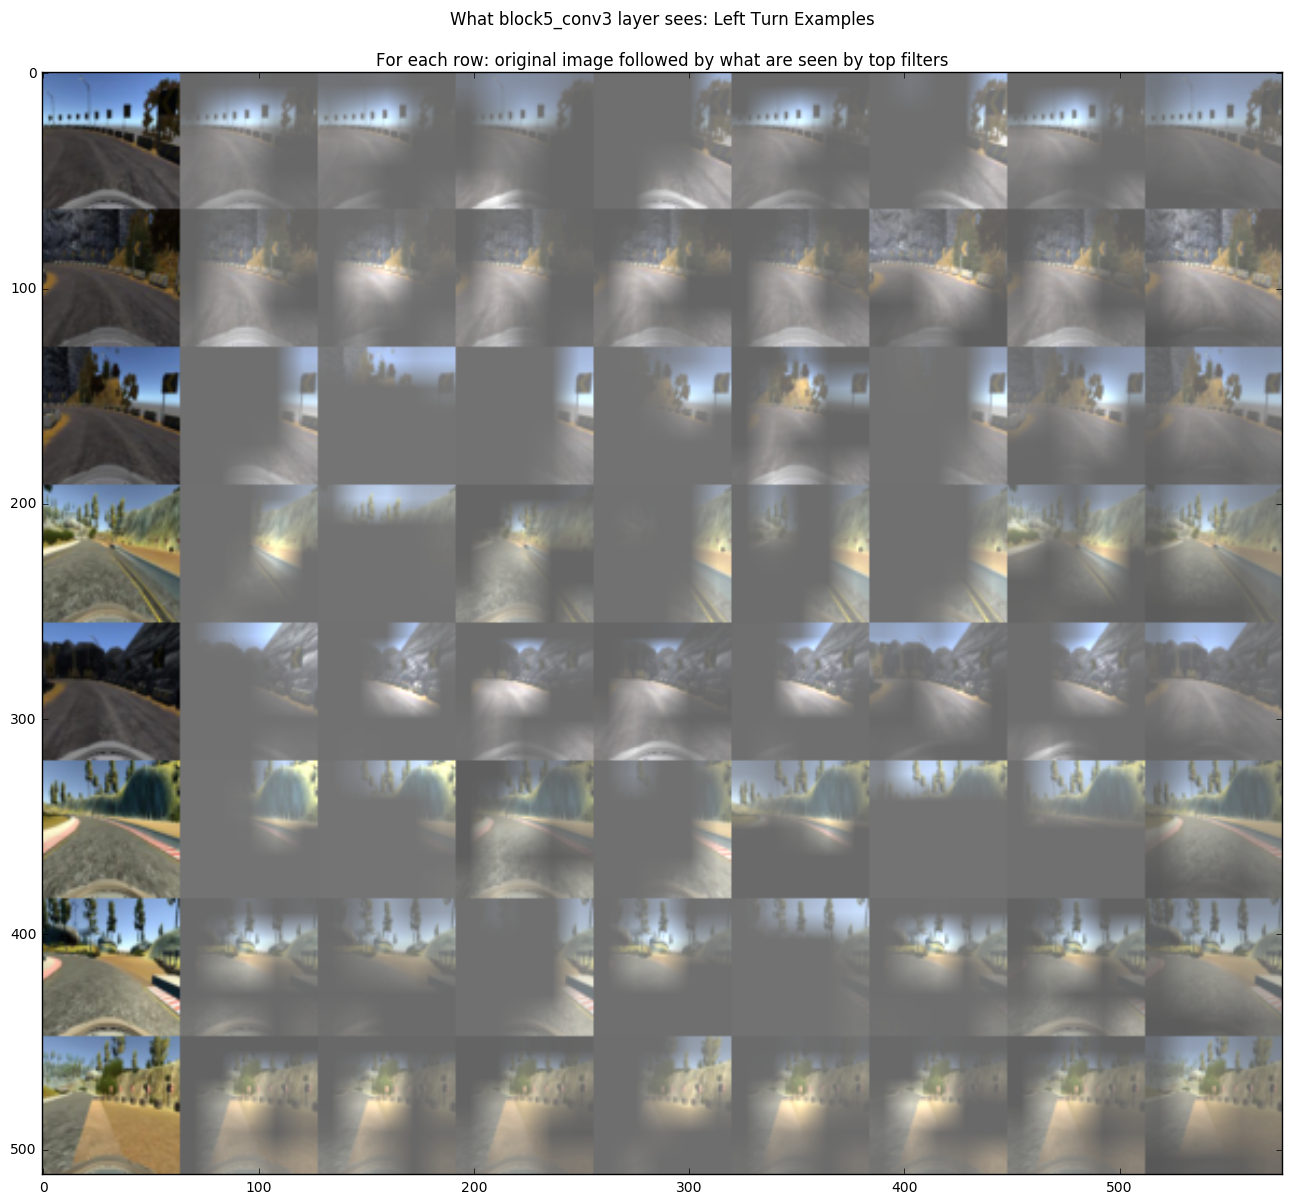

In [99]:
left_steer_imgs = list(df[df.steer < -0.75].image.sample(8))
left_steer_filter_plots = visualize_outputs(left_steer_imgs, topn=8)
plt.figure(figsize = (16, 16))
plt.imshow(left_steer_filter_plots)
plt.title("""What block5_conv3 layer sees: Left Turn Examples
          \nFor each row: original image followed by what are seen by top filters""")

## Some obervations
- VGG model is really good at finding lane markings, basically anything that look like lines - which is a good feature in SDC modelling
- There are some redundancy in filters, due to the dropout setting in my model

building vgg16_pretrained model


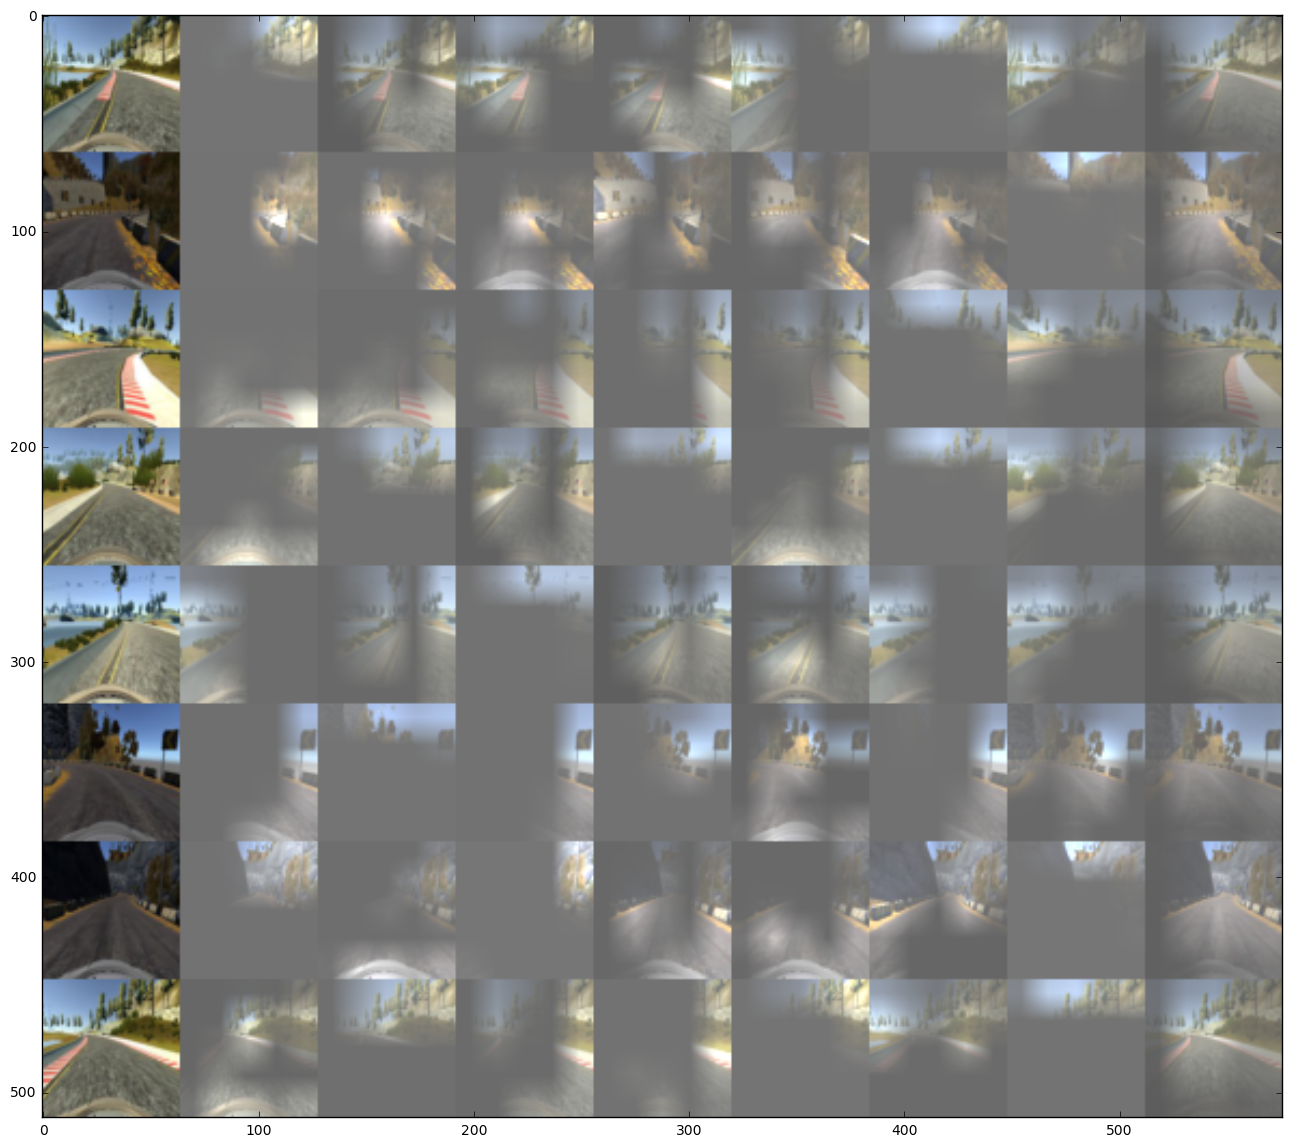

In [100]:
big_error_imgs = list(df[df.error > 0.75].image.sample(8))
big_error_filter_plots = visualize_outputs(big_error_imgs, topn=8)
plt.figure(figsize = (16, 16))
plt.imshow(big_error_filter_plots)